<b>Классификация по тональности</b>

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.
Тексты хранятся в json-ах в массиве responses.
Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

In [4]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:46, 1889.23it/s]



Посмотрим на пример отзыва:

In [7]:
responses[28]

{'city': 'г. Одинцово (Московская обл.)',
 'rating_not_checked': False,
 'title': 'Благодарственное письмо',
 'num_comments': 1,
 'bank_license': 'лицензия № 1481',
 'author': 'Wanesoft',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-05 19:01:18',
 'text': 'Выражаю благодарность персоналу дополнительного офиса в городе Одинцово по улице Молодежная, а так же начальнику безопасности Михаилу Робертовичу! Получая наличные в банкомате, по случайному стечению обстоятельств, денежные средства были мною забыты непосредственно в лотке выдачи. На следующий день я был оперативно проинформирован, деньги в полном объеме возвращены (30 000 рублей).',
 'rating_grade': None}

## Часть 1. Анализ текстов

### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [8]:
df = pd.DataFrame.from_records(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [12]:
df.groupby(['city', 'bank_name']).size().sort_values(ascending=False).reset_index(name='responses_count') 

,city,bank_name,responses_count
0,г. Москва,Сбербанк России,8146
1,г. Москва,Альфа-Банк,3871
2,г. Москва,Русский Стандарт,2801
3,г. Москва,ВТБ 24,2714
4,г. Санкт-Петербург,Сбербанк России,2434
...,...,...,...
18764,"г. Москва, Отделение ""Жулебинское""",Московский Кредитный Банк,1
18765,"г. Москва, ""Китай-город""",Фора-Банк,1
18766,"г. Москва, Ветошный пер",Восточный Экспресс Банк,1
18767,"г. Москва, Видное",Сбербанк России,1


<AxesSubplot:>

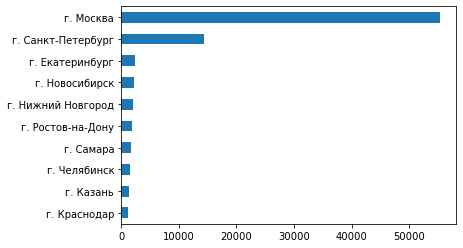

In [221]:
top_10_cities = (df['city'].value_counts()).iloc[:10]
top_10_cities.sort_values().plot(kind='barh')

<AxesSubplot:>

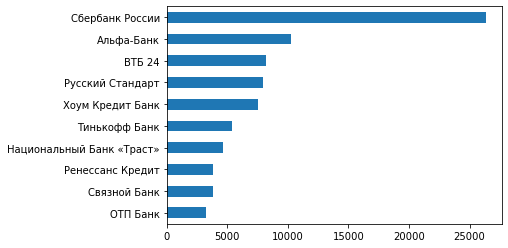

In [220]:
top_10_banks = (df['bank_name'].value_counts()).iloc[:10]
top_10_banks.sort_values().plot(kind='barh')

### 2. Постройте гистограмы длин слов в символах и в словах
построить гистограмму длин отзывов в словах и символах. Например отзыв “банк хороший” - это 2 слова и 12 символов (с пробелом).

In [57]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [58]:
from nltk import tokenize
from nltk.tokenize import word_tokenize

In [17]:
df['characters_count'] = df.text.str.len()
df['words_count'] = df.apply(lambda x: len([token for token in word_tokenize(x['text']) if token not in punctuation]), axis=1)

array([[<AxesSubplot:title={'center':'characters_count'}>]], dtype=object)

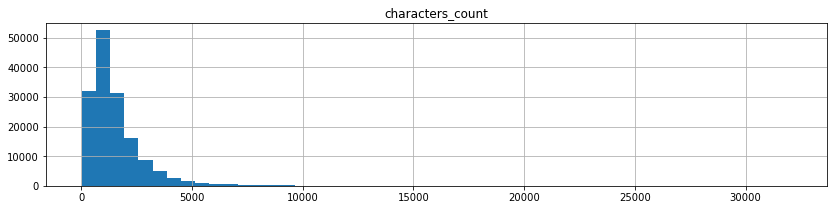

In [18]:
df.hist(column='characters_count', bins = 50, figsize=(14,3))

array([[<AxesSubplot:title={'center':'words_count'}>]], dtype=object)

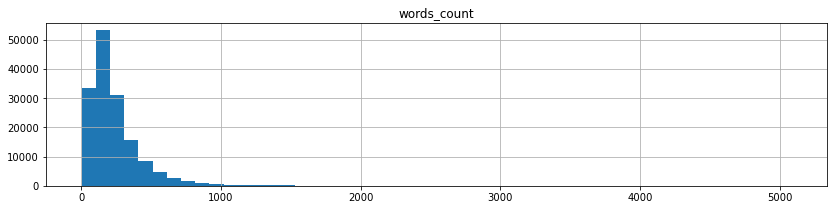

In [19]:
df.hist(column='words_count', bins = 50, figsize=(14,3))

### 3. Найдите 10 самых частых:
1) слов
2) слов без стоп-слов
3) лемм
4) существительных

можно выполнить на выборке размера 10000

In [55]:
from collections import Counter

In [59]:
punctuation_upd = punctuation+"`"+"'"
punctuation_upd

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~`\''

In [22]:
df['text_lower'] = df.text.str.lower()

In [23]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,characters_count,words_count,text_lower
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,1523,222,добрый день! я не являюсь клиентом банка и пор...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,1026,136,доброго дня! являюсь держателем зарплатной кар...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,588,93,здравствуйте! дублирую свое заявление от 03.0...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,740,124,добрый день!! я открыл расчетный счет в сберба...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,1896,308,"04.03.2015 г. взяла кредит в вашем банке, заяв..."


#### 10 самых частых слов

In [24]:
corpus = [token for response in df.text_lower for token in word_tokenize(response) if token not in punctuation_upd]

In [27]:
freq_dict = Counter(corpus)

In [28]:
freq_dict.most_common(10)

[('в', 1322516),
 ('и', 1054485),
 ('не', 851742),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454545),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263958)]

#### 10 самых частых слов без стоп-слов

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060]
[nltk_data]     Попытка установить соединение была безуспешной, т.к.
[nltk_data]     от другого компьютера за требуемое время не получен
[nltk_data]     нужный отклик, или было разорвано уже установленное
[nltk_data]     соединение из-за неверного отклика уже подключенного
[nltk_data]     компьютера>


False

In [30]:
from nltk.corpus import stopwords
stopwords_ru = stopwords.words('russian')
print(stopwords_ru)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [73]:
corpus_wo_stopwords = [token for response in df.text_lower for token in word_tokenize(response) if not (token in punctuation_upd or token in stopwords_ru)]

In [32]:
freq_dict_wo_stopwords = Counter(corpus_wo_stopwords)

In [33]:
freq_dict_wo_stopwords.most_common(10)

[('банка', 263958),
 ('``', 220777),
 ("''", 215526),
 ('банк', 196303),
 ('это', 183054),
 ('деньги', 130062),
 ('...', 113647),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80282)]

#### 10 самых частых лемм

In [35]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

In [36]:
df_1k = df[:100]

In [37]:
corpus_lemma = [token for response in df_1k.text for token in mystem_analyzer.lemmatize(response) if not (token in punctuation_upd or token in stopwords_ru)]

In [38]:
freq_dict_lemma = Counter(corpus_lemma)

In [40]:
freq_dict_lemma.most_common(20)

[(' ', 13531),
 (', ', 1195),
 ('. ', 718),
 ('банк', 308),
 ('карта', 162),
 ('это', 126),
 ('кредит', 110),
 (' (', 101),
 ('\n', 97),
 ('! ', 85),
 ('счет', 82),
 (' - ', 79),
 ('весь', 75),
 ('сумма', 75),
 ('клиент', 73),
 ('день', 71),
 ('\xa0', 68),
 ('который', 66),
 ('деньги', 66),
 ('договор', 63)]

#### 10 самых частых существительных

In [41]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [60]:
freq_dict_wo_stopwords

Counter({'добрый': 18544,
         'день': 75996,
         'являюсь': 19694,
         'клиентом': 25939,
         'банка': 263958,
         'поручителем': 982,
         'кредитному': 3064,
         'договору': 7695,
         'также': 30477,
         'каким-либо': 281,
         'другим': 3962,
         'лицом': 1533,
         'письменно': 1217,
         'оформившим': 13,
         'отношения': 6807,
         'банком': 37787,
         'поводу': 10149,
         'урегулирования': 622,
         'чьей-либо': 10,
         'задолженности': 14943,
         'начиная': 1901,
         'марта': 10295,
         '2015': 3376,
         'года': 55398,
         'начали': 4828,
         'приходить': 3805,
         'бесконечные': 320,
         'письма': 5369,
         'ооо': 5043,
         '``': 220777,
         'примо': 2,
         'коллект': 6,
         "''": 215526,
         'адрес': 11661,
         'город': 2981,
         'москва': 5997,
         'уваровский': 1,
         'переулок': 250,
         'дом

In [78]:
word_df = pd.DataFrame.from_dict(freq_dict_wo_stopwords, orient='index').reset_index()
word_df = word_df.rename(columns={'index':'word', 0:'count'})
word_df['normal_form'] = word_df.apply(lambda x: pymorphy2_analyzer.parse(x['word'])[0].normal_form, axis=1)
word_df['POS'] = word_df.apply(lambda x: pymorphy2_analyzer.parse(x['word'])[0].tag.POS, axis=1)
word_df.head()

,word,count,normal_form,POS
0,добрый,18544,добрый,ADJF
1,день,75996,день,NOUN
2,являюсь,19694,являться,VERB
3,клиентом,25939,клиент,NOUN
4,банка,263958,банк,NOUN


In [93]:
nouns_count = word_df[word_df.POS == 'NOUN'].groupby(['normal_form', 'POS'])['count'].agg("sum").reset_index().sort_values(by=['count'], ascending=False)
nouns_count.head(10)

,normal_form,POS,count
13823,банк,NOUN,624274
33899,карта,NOUN,331816
24843,деньга,NOUN,178338
24811,день,NOUN,172636
37582,кредит,NOUN,154865
50699,отделение,NOUN,143616
70449,счёт,NOUN,140510
67866,сотрудник,NOUN,133662
35034,клиент,NOUN,132908
69934,сумма,NOUN,110914


### 4. Постройте кривые Ципфа и Хипса

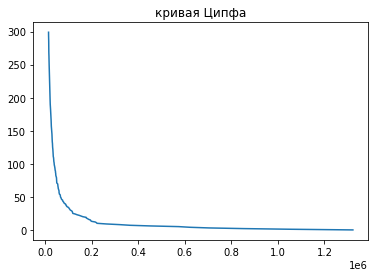

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.title("кривая Ципфа")
plt.show()

In [217]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation_upd])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(sum(cnt.values()))))

100%|██████████| 153499/153499 [1:10:29<00:00, 36.29it/s]


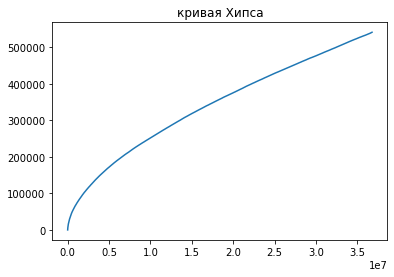

In [218]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.title("кривая Хипса")
plt.show()

In [87]:
n_words[1]

268

In [86]:
len(n_tokens[2])

5566

ValueError: x and y must have same first dimension, but have shapes (1,) and (153499,)

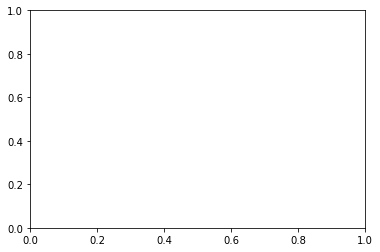

### 5. Ответьте на следующие вопросы:
1) какое слово встречается чаще, "сотрудник" или "клиент"?
2) сколько раз встречается слова "мошенничество" и "доверие"?

In [96]:
nouns_count[(nouns_count.normal_form == 'сотрудник') | (nouns_count.normal_form == 'клиент')].sort_values(by=['count'], ascending=False)

,normal_form,POS,count
67866,сотрудник,NOUN,133662
35034,клиент,NOUN,132908


In [97]:
nouns_count[(nouns_count.normal_form == 'мошенничество') | (nouns_count.normal_form == 'доверие')].sort_values(by=['count'], ascending=False)

,normal_form,POS,count
44053,мошенничество,NOUN,3228
25785,доверие,NOUN,2098


### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 
Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [34]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [30]:
df_sample = df[(df.rating_grade==1)].sample(n=14000).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=14000))

df_sample.rating_grade.value_counts()

1.0    14000
5.0    14000
Name: rating_grade, dtype: int64

In [36]:
df_sample.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,characters_count,words_count,text_lower
58498,г. Москва,False,"Банк не исполняет обязательств, даже по малым ...",9,лицензия № 2581(отозвана),ВладимирВладимир,С банк,2014-02-07 01:04:00,"Весит налоговый платёж в отделении ""Центральны...",1.0,1167,175,"весит налоговый платёж в отделении ""центральны..."
40579,г. Хабаровск,False,Ужасное обслуживание. Хабаровск,0,лицензия № 1481,khk,Сбербанк России,2014-07-16 17:57:00,"Добрый день! Суть проблемы в том, что при поп...",1.0,2883,446,"добрый день! суть проблемы в том, что при поп..."
68925,г. Москва,False,Частичное досрочное погашение потребительского...,0,лицензия № 2557,katerina1102114,Ситибанк,2013-11-01 07:19:00,"Являюсь бывшим сотрудником и, соответственно, ...",1.0,931,136,"являюсь бывшим сотрудником и, соответственно, ..."
83200,г. Москва,False,Опять списали комиссию по страховке!,0,лицензия № 2268,oprst,МТС Банк,2013-05-22 16:30:00,"Имею карту МТС-деньги, номер *3301. 24.12.2012...",1.0,1019,140,"имею карту мтс-деньги, номер *3301. 24.12.2012..."
146473,None,False,Хамство кассира в оперкассе №5,8,лицензия № 2748,Эмма,Банк Москвы,2007-08-31 13:21:00,"Уважаемое руководство банка! Обратите, пожалуй...",1.0,793,130,"уважаемое руководство банка! обратите, пожалуй..."


In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [68]:
df_rating_1 = df_sample[(df_sample.rating_grade==1)]
df_rating_5 = df_sample[(df_sample.rating_grade==5)]

In [76]:
corpus_rating_1_wo_stopwords = [token for response in df_rating_1.text_lower for token in word_tokenize(response) if not (token in punctuation_upd or token in stopwords_ru)]

In [80]:
corpus_rating_5_wo_stopwords = [token for response in df_rating_5.text_lower for token in word_tokenize(response) if not (token in punctuation_upd or token in stopwords_ru)]

In [81]:
vec1 = TfidfVectorizer(ngram_range = (1,1))
bow1_1 = vec1.fit_transform(corpus_rating_1_wo_stopwords)
bow5_1 = vec1.fit_transform(corpus_rating_5_wo_stopwords)

In [82]:
sums = bow1_1.sum(axis = 0)
data1 = []
for col, term in enumerate(vec1.get_feature_names()):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords 1-grams for rating_grade 1 : \n", words.head(10))



Words 1-grams for rating_grade 1 : 
                term          rank
15749      вольский  28764.199110
15745        вольны  21357.568654
28350    замеченную  14845.476503
40817    малолетних  11311.395534
40818     малолюдно  10453.899633
36692  контролирует   8861.315865
44093   наблюдалась   8455.686476
62815      поджидал   8331.212790
28344    замечаются   8071.437515
15759        воняет   7074.885852


In [83]:
sums = bow5_1.sum(axis = 0)
data1 = []
for col, term in enumerate(vec1.get_feature_names()):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords 1-grams for rating_grade 5 : \n", words.head(10))



Words 1-grams for rating_grade 5 : 
           term          rank
9638     банка  21300.858336
9633      банк  16913.633793
100233     это  14942.038530
58026    очень  14867.927235
22066   деньги   7926.431089
34316    карту   7740.960341
9650     банке   7311.706066
37763   кредит   6929.723271
16407    время   6528.011668
34322    карты   6463.519395


In [84]:
vec2 = TfidfVectorizer(ngram_range = (2,2))
bow1_2 = vec2.fit_transform(corpus_rating_1_wo_stopwords)
bow5_2 = vec2.fit_transform(corpus_rating_5_wo_stopwords)

In [85]:
sums = bow1_2.sum(axis = 0)
data1 = []
for col, term in enumerate(vec2.get_feature_names()):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords 2-grams for rating_grade 1 : \n", words.head(10))



Words 2-grams for rating_grade 1 : 
                         term        rank
9408               шри ланке  567.000000
9407               шри ланка  424.098798
7288             полтора два  341.000000
2168                   97 70  273.490611
7225  подсказкой автозаменой  254.655346
1428                   27 24  219.915528
2403      fashion fulloption  218.436992
7289             полторы две  197.000000
2293          cirrus maestro  176.961169
1426                   27 11  155.617165


In [86]:
sums = bow5_2.sum(axis = 0)
data1 = []
for col, term in enumerate(vec2.get_feature_names()):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords 2-grams for rating_grade 5 : \n", words.head(10))



Words 2-grams for rating_grade 5 : 
                term         rank
5156  интернет банк  1282.490959
9354         что то  1131.992950
5043          из за  1109.000000
5392         как то   968.000000
4243         где то   638.521109
4142       все таки   604.000000
5724     колл центр   485.532436
5404       какие то   441.000000
5427       какой то   392.000000
3458    альфа банка   383.000000


## Часть 2. Тематическое моделирование 
Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [3]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [9]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [10]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [11]:
from gensim.models import lsimodel

In [25]:
%%time
lsi20 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)

Wall time: 6min 9s


In [26]:
lsi20.show_topics(5)

[(0,
  '0.126*"-" + 0.118*"я" + 0.113*"мне" + 0.089*"меня" + 0.085*"Я" + 0.085*"деньги" + 0.082*"о" + 0.081*"у" + 0.080*"все" + 0.079*"банка"'),
 (1,
  '-0.175*"-" + 0.145*"заявление" + 0.136*"г." + 0.120*"руб." + -0.118*"вклад" + 0.112*"денежных" + 0.108*"000" + 0.107*"средства" + 0.107*"средств" + 0.101*"денежные"'),
 (2,
  '0.231*"звонки" + 0.185*"кредит" + -0.182*"деньги" + -0.168*"банкомат" + -0.165*"карту" + 0.161*"номер" + -0.160*"карты" + 0.125*"мой" + -0.114*"карта" + 0.108*"телефона"'),
 (3,
  '0.249*"номер" + -0.196*"кредит" + 0.167*"звонки" + -0.164*"000" + -0.147*"кредита" + -0.146*"руб." + -0.136*"сумму" + 0.127*"карта" + 0.127*"телефона" + 0.113*"карту"'),
 (4,
  '-0.204*"кредит" + 0.174*"вклад" + 0.168*"вклада" + -0.112*"сказали," + 0.111*"средств" + 0.104*"денежных" + -0.103*"мне" + 0.098*"–" + 0.095*"Банка" + -0.091*"000"')]

In [27]:
%%time
lsi35 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=35)

Wall time: 5min 13s


In [28]:
lsi35.show_topics(5)

[(0,
  '0.126*"-" + 0.118*"я" + 0.113*"мне" + 0.089*"меня" + 0.085*"Я" + 0.085*"деньги" + 0.082*"о" + 0.081*"у" + 0.080*"все" + 0.079*"банка"'),
 (1,
  '-0.178*"-" + 0.144*"заявление" + 0.136*"г." + 0.120*"руб." + -0.116*"вклад" + 0.111*"денежных" + 0.109*"000" + 0.105*"средств" + 0.104*"средства" + 0.100*"размере"'),
 (2,
  '0.230*"звонки" + 0.184*"кредит" + -0.182*"деньги" + -0.171*"банкомат" + -0.167*"карту" + 0.164*"номер" + -0.160*"карты" + 0.126*"мой" + -0.115*"карта" + 0.110*"телефона"'),
 (3,
  '0.252*"номер" + -0.207*"кредит" + 0.169*"звонки" + -0.167*"000" + -0.152*"кредита" + -0.148*"руб." + -0.137*"сумму" + 0.131*"телефона" + 0.126*"карта" + 0.114*"карту"'),
 (4,
  '-0.196*"кредит" + 0.181*"вклад" + 0.176*"вклада" + -0.113*"сказали," + 0.111*"средств" + -0.106*"мне" + 0.105*"–" + 0.102*"денежных" + 0.096*"Банка" + -0.084*"сказала,"')]

## Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 
-грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: 
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [29]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [32]:
df_sample_10k = df[(df.rating_grade==1)].sample(n=10000).copy()
df_sample_10k = df_sample_10k.append(df[(df.rating_grade==5)].sample(n=10000))

df_sample_10k.rating_grade.value_counts()

1.0    10000
5.0    10000
Name: rating_grade, dtype: int64

In [35]:
x_train, x_test, y_train, y_test = train_test_split(df_sample_10k.text, df_sample_10k.rating_grade, test_size = 0.2)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [40]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95      2009
         5.0       0.95      0.96      0.95      1991

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [42]:
vec = CountVectorizer(analyzer = 'char', ngram_range=(4, 6))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96      2004
         5.0       0.95      0.96      0.96      1996

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [46]:
from sklearn import svm
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [52]:
# вариант 1
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'tsvd__n_components': [10],
    'clf__penalty': ['l1', 'l2']
}

clf_tf_idf_TruncatedSVD.fit(x_train, y_train)
pred=clf_tf_idf_TruncatedSVD.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.85      0.85      0.85      1973
         5.0       0.85      0.85      0.85      2027

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



In [53]:
# вариант 2
clf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_clf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25],
    'clf__penalty': ['l1']
}

clf_LDA.fit(x_train, y_train)
pred=clf_LDA.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.90      0.86      0.88      2055
         5.0       0.86      0.90      0.88      1945

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



вариант 2 - наиболее удачный